# Machine Learning Pipeline for Multi-class Classification  
**Purpose**: Benchmark several re-sampling strategies (SMOTE, up/down-sampling) on a list of open datasets with a fully-robust, Stratified-K-Fold CV workflow.  

## Step-1 – Import libraries

In [1]:
# Core
import os, pathlib, warnings, itertools, joblib
warnings.filterwarnings("ignore")

# Scientific
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn utilities
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)

# Sampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Classifiers (pick any – here we use RandomForest as a strong default)
from sklearn.ensemble import RandomForestClassifier

## Step-2 – List of datasets  
(Each dataset must be a CSV whose last column is the multi-class target.)

In [2]:
DATA_DIR = pathlib.Path("datasets")          # folder that contains the csv files
CSV_FILES = sorted(DATA_DIR.glob("*.csv"))   # auto list
assert CSV_FILES, f"No CSV found in {DATA_DIR.resolve()}"
print("Datasets to process:", [f.stem for f in CSV_FILES])

Datasets to process: ['wisconsin']


## Helper – evaluation helper for multi-class

In [3]:
def score_report(y_true, y_pred, average="macro"):
    """Return dict with macro & weighted metrics + overall accuracy."""
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    return dict(accuracy=acc, precision=pre, recall=rec, f1=f1)

def weighted_scores(y_true, y_pred):
    return score_report(y_true, y_pred, average="weighted")

## Step-3 … Step-8 – Master routine

In [4]:
SAMPLERS = {
    "None": None,
    "SMOTE": SMOTE(random_state=42),
    "UpSample": RandomOverSampler(random_state=42),
    "DownSample": RandomUnderSampler(random_state=42)
}

CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
CLF = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

results = []   # will collect rows

for csv_path in CSV_FILES:
    ds_name = csv_path.stem
    print(f"\n===== Dataset : {ds_name} =====")
    
    # Step-3: load
    df = pd.read_csv(csv_path)
    X = df.iloc[:, :-1].copy()
    y = LabelEncoder().fit_transform(df.iloc[:, -1])  # Step-4
    
    # quick numeric check
    cat_cols = X.select_dtypes(exclude=np.number).columns
    if len(cat_cols):
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
    for sampler_name, sampler_obj in SAMPLERS.items():
        fold_scores = []
        
        for fold, (tr_idx, val_idx) in enumerate(CV.split(X, y), 1):
            X_train, X_val = X.iloc[tr_idx], X.iloc[val_idx]
            y_train, y_val = y[tr_idx], y[val_idx]
            
            # Step-6 – missing-value imputation (fit on train)
            imp = SimpleImputer(strategy="median")
            X_train_imp = imp.fit_transform(X_train)
            X_val_imp = imp.transform(X_val)
            
            # Step-7 – sampling (only on training)
            if sampler_obj:
                X_train_imp, y_train = sampler_obj.fit_resample(X_train_imp, y_train)
            
            # Fit classifier
            CLF.fit(X_train_imp, y_train)
            y_pred = CLF.predict(X_val_imp)
            
            # Step-8 – metrics
            macro = score_report(y_val, y_pred, "macro")
            weighted = weighted_scores(y_val, y_pred)
            fold_scores.append({
                "fold": fold,
                "accuracy": macro["accuracy"],
                "macro_precision": macro["precision"],
                "macro_recall": macro["recall"],
                "macro_f1": macro["f1"],
                "weighted_precision": weighted["precision"],
                "weighted_recall": weighted["recall"],
                "weighted_f1": weighted["f1"]
            })
        
        # Average across folds
        df_fold = pd.DataFrame(fold_scores)
        mean_row = df_fold.mean(numeric_only=True).to_dict()
        mean_row.update({"dataset": ds_name, "sampler": sampler_name})
        results.append(mean_row)
        print(f"{sampler_name:12} | macro-F1 = {mean_row['macro_f1']:.3f} | acc = {mean_row['accuracy']:.3f}")


===== Dataset : wisconsin =====
None         | macro-F1 = 0.970 | acc = 0.972
SMOTE        | macro-F1 = 0.970 | acc = 0.972
UpSample     | macro-F1 = 0.968 | acc = 0.971
DownSample   | macro-F1 = 0.973 | acc = 0.975


## Step-9 – Compile & visualise


Preview of aggregated results


,fold,accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1,dataset,sampler
0,3.0,0.972177,0.967558,0.971832,0.969548,0.972552,0.972177,0.972241,wisconsin,None
1,3.0,0.972177,0.966519,0.973752,0.969687,0.973184,0.972177,0.972299,wisconsin,SMOTE
2,3.0,0.970717,0.966340,0.969749,0.967938,0.971018,0.970717,0.970778,wisconsin,UpSample
3,3.0,0.975107,0.969369,0.976959,0.972863,0.975833,0.975107,0.975215,wisconsin,DownSample


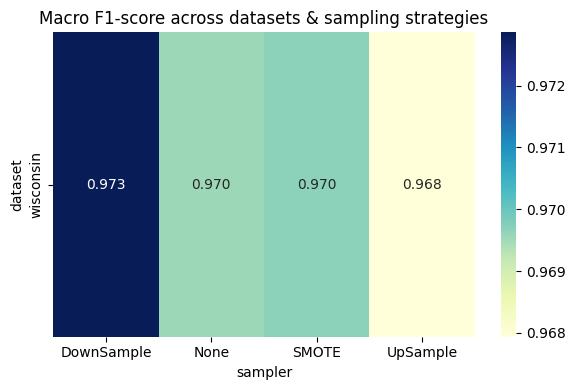

In [5]:
RESULT = pd.DataFrame(results)
print("\nPreview of aggregated results")
display(RESULT.head())

# Heatmap – macro F1
pivot = RESULT.pivot(index="dataset", columns="sampler", values="macro_f1")
plt.figure(figsize=(6, 4))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Macro F1-score across datasets & sampling strategies")
plt.tight_layout()

## Bar-plot for each dataset

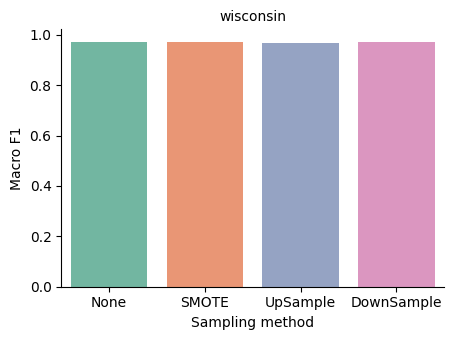

In [6]:
g = sns.catplot(
    data=RESULT, kind="bar",
    x="sampler", y="macro_f1", col="dataset",
    height=3.5, aspect=1.2, col_wrap=3, palette="Set2"
)
g.set_titles("{col_name}")
g.set_axis_labels("Sampling method", "Macro F1")
plt.tight_layout()

## Step-10 – Export artefacts

In [7]:
OUT_DIR = pathlib.Path("output")
OUT_DIR.mkdir(exist_ok=True)

# CSV
RESULT.to_csv(OUT_DIR/"benchmark_results.csv", index=False)

# Plots to PDF
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(OUT_DIR/"benchmark_plots.pdf") as pdf:
    # heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title("Macro F1-score across datasets & sampling strategies")
    pdf.savefig(); plt.close()
    
    # bar-plots
    g = sns.catplot(
        data=RESULT, kind="bar",
        x="sampler", y="macro_f1", col="dataset",
        height=3.5, aspect=1.2, col_wrap=3, palette="Set2"
    )
    g.set_titles("{col_name}")
    g.set_axis_labels("Sampling method", "Macro F1")
    plt.tight_layout()
    pdf.savefig(); plt.close()

print("✅ All artefacts saved to", OUT_DIR.resolve())

✅ All artefacts saved to /home/omarf/Downloads/Documents/papers/Perovskite ML papers/A_Multi_class_Dataset_Comparison/output


### End of notebook – you can now:
1. Drop any CSV (with multi-class target in the last column) into the `datasets/` folder  
2. Re-run all cells to obtain an updated benchmark report  
3. Inspect `output/benchmark_results.csv` and `output/benchmark_plots.pdf`  